# TP4: Análisis de datos epiGBS (*epi-Genotyping By Sequencing*)

**Nota**: Este cuaderno asume que el [TP0](https://colab.research.google.com/github/VeronicaNoe/EpiEvo/blob/main/cuadernos/TP0_espacio_de_trabajo.ipynb) ha sido completado con éxito.


# Contenido

**Objetivo:** Familiarizarse con la identificación de citosinas metiladas usando datos [epiGBS](https://www.nature.com/articles/nmeth.3763) del diente de León _Taraxacum officinalis_.


<p align='left'>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Eightyfivedandelion.JPG/1024px-Eightyfivedandelion.JPG" width=350/>
</p >



0.   [Preparación de cuaderno](#step-0)
1.   [Preparación del espacio de trabajo en R](#step-1)
2.   [Análisis de datos obtenidos por *RRBS*](#step-2)
  1.   [Introducción](#step-2.1)
  2.   [Explorar datos](#step-2.2)
  3.   [Control de calidad](#step-2.3)
  4.   [Caracterización global de la metilación](#step-2.4)
  5.   [Citosinas diferencialmente metiladas](#step-2.5)
3.   [OPCIONAL: Guardar en Drive](#step-3)



<a name="step-0"></a>
# Preparación del cuaderno

Contectar el cuaderno con Google Drive.

Los siguientes pasos muestran como realizar dicha conexión:

1. Presionar el botón play, cliquea el enlace mostrado en `Go to this URL in a browser`.
<img src="https://raw.githubusercontent.com/VeronicaNoe/EpiEvo/main/img/0/00_paso1a.png" width="550"/>

2. Copie el código de autenticación.
<img src="https://raw.githubusercontent.com/VeronicaNoe/EpiEvo/main/img/0/00_paso1b.png" width="550"/>

3. Ingresar dicho código en el campo `Enter authorization code`.
<img src="https://raw.githubusercontent.com/VeronicaNoe/EpiEvo/main/img/0/00_paso1c.png" width="550"/>

In [ ]:
#@title Solicitar acceso a Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Para trabajar de forma ordenada, se crearán 3 carpetas en colab:
- *rawData*: en donde estarán los archivos necesarios para trabajar (**input**)
- *results*: en donde se guardarán los archivos generados (**output**)
- *plots*: en donde se guardarán los pdf de las figuras (**output**)

In [ ]:
#@title Desde el navegador de la izquierda, revisar los directorios
%%bash
mkdir {rawData,plots,results}
rm -r sample_data/ # eliminarmos la carpeta que está por default en colab
ls

drive
plots
rawData
results


En el directorio *rawData* cargaremos los inputs



In [ ]:
#@title Cargar archivos
#@title Descargar archivos en el directorio
%%bash
cp -r /content/drive/MyDrive/EpiEvo/epievo_data/4/* /content/rawData
ls rawData

commonFunctions.R
Design.txt
mergedAnnot.csv
methylation.bed


<a name="step-1"></a>
# Preparación del espacio de trabajo en R




In [ ]:
#@title Cargar R
%load_ext rpy2.ipython

## Instalar paquetes, cargar librerías y establecer directorio de trabajo
<font color="red">**NOTA**</font>: En algún punto, le va a solicitar que decida si se actualizan los paquetes. Es recomendable que <font color="red">**NO actualice**</font> (opción `n`).

<p align="left">
<img src="https://raw.githubusercontent.com/VeronicaNoe/EpiEvo/main/img/Kahoot_img.png" width="100"/> 
</p>


In [ ]:
%%R
#@title Instalar paquetes de CRAN (ejecutar)
install.packages(c("data.table","reshape2","ggplot2","vioplot",
"qqman", "vegan","plyr"),quiet=TRUE)

R[write to console]: also installing the dependencies ‘sm’, ‘zoo’, ‘calibrate’, ‘permute’




In [ ]:
%%R
#@title Instalar paquetes de Bioconductor (ejecutar)
if (!requireNamespace("BiocManager"))
    install.packages("BiocManager", quiet = TRUE)
BiocManager::install("DSS", quiet=TRUE)  

R[write to console]: Loading required namespace: BiocManager

R[write to console]: Failed with error:  
R[write to console]: 
R[write to console]: ‘there is no package called ‘BiocManager’’
R[write to console]: 
R[write to console]: 

R[write to console]: 'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


R[write to console]: Bioconductor version 3.14 (BiocManager 1.30.16), R 4.1.1 (2021-08-10)

R[write to console]: Installing package(s) 'BiocVersion', 'DSS'

R[write to console]: also installing the dependencies ‘rjson’, ‘formatR’, ‘zlibbioc’, ‘bitops’, ‘XML’, ‘GenomicAlignments’, ‘BiocIO’, ‘restfulr’, ‘Rhtslib’, ‘lambda.r’, ‘futile.options’, ‘XVector’, ‘RCurl’, ‘GenomeInfoDbData’, ‘R.oo’, ‘R.methodsS3’, ‘matrixStats’, ‘sparseMatrixStats’, ‘rtracklayer’, ‘Rsamtools’, ‘rhdf5filters’, ‘Rhdf5lib’, ‘BiocGenerics’, ‘futile.logger’, ‘snow’, ‘BH’, ‘GenomicRanges’, ‘SummarizedExperime

Update all/some/none? [a/s/n]: n


In [ ]:
%%R
#@title Cargar todos los paquetes (ejecutar)
suppressPackageStartupMessages({
  library("data.table")
  library("reshape2")
  library("ggplot2")
  library("vioplot")
  library("DSS")
  library("qqman")
  library("vegan")
  library("plyr")
  source(file.path("/content/rawData", "commonFunctions.R"))
})


In [ ]:
%%R
#@title Definir directorio de trabajo
setwd("/content/results")
getwd()

[1] "/content/results"


<a name="step-2"></a>
# Análisis de datos obtenidos por *epiGBS*


<a name="step-2.1"></a>
## Introducción

A diferencia de la técnica [RRBS](https://colab.research.google.com/github/VeronicaNoe/EpiEvo/blob/main/cuadernos/TP2_RRBS.ipynb), con [epiGBS](https://www.nature.com/articles/nmeth.3763) no es necesario un genoma de referencia.

La [pipeline](https://github.com/nioo-knaw/epiGBS2) desarrollada para este método realiza una construcción _de novo_ de la referencia a partir de los reads de la secuenciación y genera el archivo con los datos de metilación (`methylation.bed`). 

Analizaremos la metilación del ADN en `accesiones` de *Taraxacum officinalis* bajo un experimento de luz.

Utilizaremos, 20 accesiones bajo condiciones de luz `control` y 20 en condiciones de sombra `shade`.

<p align="left">
<img src="https://raw.githubusercontent.com/VeronicaNoe/EpiEvo/main/img/4/epiGBS_design.png" width="600"/> 
</p>


Para realizar la anotación de las secuencias, se utilizó [DIAMOND](https://www.nature.com/articles/nmeth.3176) para identificar genes putativos y [RepeatMasker](https://www.repeatmasker.org/) para identificar elementos transponibles.

<a name="step-2.2"></a>
## Explorar los datos

In [ ]:
#@title Ejecutar
%%R
#@title
myData <- f.load.methylation.bed("/content/rawData/methylation.bed")

R[write to console]: |--------------------------------------------------|
|
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wr

La tabla de datos (`myData`) contiene la información de las `citosinas secuenciadas en las filas` mientras que en las `columnas` se encuentra diferente información:


> Las primeras 4 columnas contiene la información de las citosinas metiladas:
  - **chr**: fragmento o cromosoma (del inglés: chromosome) consenso de las muestras
  - **pos**: posición dentro del fragmento 5'->3'
  - **context**: nucleótidos alrededor de la citosina metilada (CG,CHH,CHG)
  - **samples_called**: número que indica en cuantas muestras se secuenció al menos una vez (1x) cada citosina.

> A partir de la 5º columna, se encuentra la información de metilación para cada muestra por duplicado:
  - Shade_40_*methylated*: la terminación **methylated** indica el número de citosinas metiladas
  - Shade_40_*total*: la terminacióón **total** indica el número total de citosinas (suma C metiladas y C no metiladas)

In [ ]:
#@title Datos crudos (ejecutar)
%%R
cat("Número de columnas =", dim(myData)[2], "\n")
cat("Número de muestras =", length(grep("_total$",colnames(myData), value = FALSE)), "\n")
cat("Número de filas =", dim(myData)[1],"\n")
cat("\n","\t\t\t\t Vista previa de la tabla:", "\n")
myData[1:5,1:10]

Número de columnas = 72 
Número de muestras = 34 
Número de filas = 3906868 

 				 Vista previa de la tabla: 
  chr pos context samples_called Shade_40_methylated Shade_40_total
1   1   8     CHH             21                  NA             NA
2   1  10     CHH             21                  NA             NA
3   1  14     CHH             21                  NA             NA
4   1  20     CHH             21                  NA             NA
5   1  25     CHG             21                  NA             NA
  Shade_30_methylated Shade_30_total Shade_37_methylated Shade_37_total
1                   0              3                   1              2
2                   0              3                   0              2
3                   0              3                   0              2
4                   0              3                   0              2
5                   2              3                   1              2


<a name="step-2.3"></a>
## Control de calidad



Se filtraran citosinas con baja cobertura y aquellas con alta cobertura. Es decir, citosinas que fueron secuenciadas pocas o muchas veces.



**Baja cobertura**: El mínimo es 10 (*10X*), se puede modificar y ser menos estrictos pero esto compromete la confianza en los datos.

**Alta cobertura**: Los valores de cobertura muy altos también son problemáticos ya que se puede detectar citosinas/posiciones diferencialmente metiladas (DMC/DMP) a aquellas C's en que la diferencia se deba a cobertura.

El umbral depende de los investigadores.
Al igual que Methylkit, usaremos el valor del cuartil 99,9

In [ ]:
%%R
#@title Ejecutar
#seleccionamos las columnas con la cobertura total
totalCols <- grep("_total$", colnames(myData), value = TRUE)
methCov <- myData[,totalCols]
colnames(methCov) <- gsub("_total$", "", colnames(methCov))
#generamos los bins para observar la distribución de la cobertura de los datos
bins<-c(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.999,1)
# generamos la distribución de la cobertura
quaCov<-quantile(methCov,bins, na.rm = TRUE) 
# set min y max
minCov<-10 # min 10X
methCov[(methCov < minCov)] <- NA
quaCov<-quantile(methCov,bins, na.rm = TRUE) 
maxCov<-quaCov[10] #99.99%
cat("Para filtrar= valor mínimo de cobertura = ", minCov, "\n")
cat("Valor máximo de cobertura = ", maxCov, "\n")
cat("\n \tRango de valores y distribución de la cobertura: \n")
print(quaCov)

Para filtrar= valor mínimo de cobertura =  10 
Valor máximo de cobertura =  1426 

 	Rango de valores y distribución de la cobertura: 
  10%   20%   30%   40%   50%   60%   70%   80%   90% 99.9%  100% 
   10    11    11    12    14    15    18    24    39  1426  4811 


**Filtrado**: 
 - Convertimos en NA todas las celdas que no cumplian con los criterios (baja | alta cobertura), 
 - Seleccionamos aquellas citosinas secuenciadas más de 10 veces y menos del max que están *presentes en el **80%** de las muestras*.



Compare esta tabla con la primera.


In [ ]:
%%R
#@title Datos filtrados (ejecutar)
methCov[(methCov < minCov)|(methCov > maxCov)] <- NA
filteredMeth<-f.filter.methylation(myData, methCov) #demora un poquito
write.table(filteredMeth, file = "/content/results/filteredMethylation", sep = '\t', col.names = TRUE, row.names = FALSE, quote = FALSE)
cat("Número de columnas=", dim(filteredMeth)[2], "\n")
cat("Número de muestras=", length(grep("_total$",colnames(filteredMeth), value = FALSE)), "\n")
cat("Número de filas=", dim(filteredMeth)[1],"\n")
cat("\n","\t\t\t\t Vista previa de la tabla:", "\n")
filteredMeth[1:5,1:20]

Número de columnas= 72 
Número de muestras= 34 
Número de filas= 31435 

 				 Vista previa de la tabla: 
     chr pos context samples_called Shade_40_methylated Shade_40_total
1563  38  23     CHG             40                  19             23
1565  38  28     CHH             40                   1             23
1566  38  36     CHH             40                   0             23
1576  38  61     CHG             40                  14             23
1581  38  81      CG             40                  21             23
     Shade_30_methylated Shade_30_total Shade_37_methylated Shade_37_total
1563                  60             68                  39             45
1565                   1             68                   0             45
1566                   2             68                   0             44
1576                  38             67                  26             45
1581                  63             68                  40             43
     Control_20_me

<a name="step-2.4"></a>
## Caracterización global de la metilación

Se generarán 3 gráficos para caracterizar la metilación global:
- Histograma: distribución de C's según el % metilación en cada contexto
- Violines: distribución de C's según el % metilación en cada contexto
- Heatmaps: % de metilación para genes, elementos transponibles, repeticiones y regiones no clasificadas.

Además, realizaremos un estudio exploratorio mediante un análisis de componentes principales para cada contexto. A partir de la matriz de distancia generada, se realizará un análisis permutacional de la varianza.

Se utilizará 
- la matriz de datos filtrados: **filteredMethylation**
- el archivo con las anotaciones para cada cromosoma/fragmento (chr): **mergedAnnot.csv**
- el archivo con el diseño experimental: **Design.txt**

In [ ]:
%%R
#@title Metilación porcentual media para cada tratamiento: *Control* y *Shade*.
infileName <- c("/content/results/filteredMethylation")
mePerc <- f.load.methylation.bed(infileName, percentages = TRUE) # see commonFunctions.R
aveData<-f.average.by.group(infileName)
cat("Porcentaje de metilación \n")
aveData[1:5,]

Porcentaje de metilación 
           Control     Shade
chr38_23 90.216000 89.825647
chr38_28  2.292176  2.348176
chr38_36  1.370118  2.504882
chr38_61 54.842941 53.046059
chr38_81 95.300647 96.849059


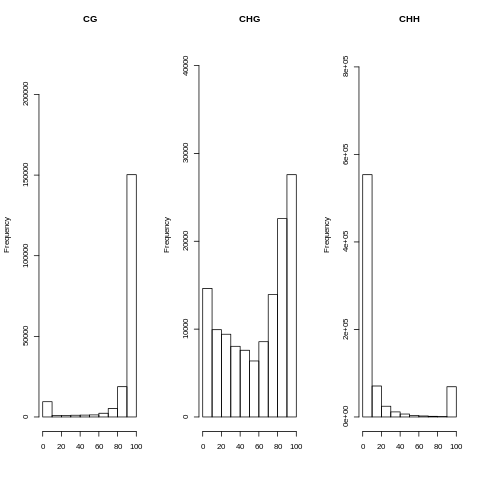

In [ ]:
#@title Histogramas por contexto
%%R
f.plot.histogram(mePerc)
#save
pdf(file.path("/content/plots/histograma.pdf"))
f.plot.histogram(mePerc)
invisible(dev.off())

Metilación porcentual 


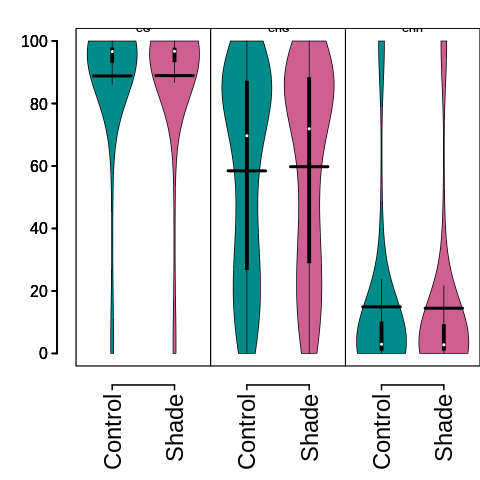

In [ ]:
# @title Violin plots
%%R
aveData<-f.average.by.group(infileName)
mePerc <- f.load.methylation.bed(infileName, percentages = TRUE) # see commonFunctions.R
allMeans<-f.plot.violin(aveData, mePerc)
cat("Metilación porcentual \n")
pdf(file.path("/content/plots/violin.pdf"))
f.plot.violin(aveData, mePerc)
dev.off()
write.csv(round(allMeans, 3), file.path("/content/results/methylationLevelsViolinPlot_means.csv"))  


In [ ]:
#@title MDS
%%R
pdf(paste0("/content/plots/isoMDS.pdf"), height = 4, width = 10)
f.plot.isoMDS(filteredMeth)
invisible(dev.off())

initial  value 36.120155 
iter   5 value 27.601499
iter  10 value 25.377226
iter  10 value 25.368984
iter  15 value 24.527043
final  value 24.411123 
converged
###
initial  value 38.022343 
iter   5 value 25.866972
iter  10 value 25.179448
final  value 24.991083 
converged
###
initial  value 38.292668 
iter   5 value 27.100305
iter  10 value 25.104175
iter  15 value 23.379774
iter  20 value 22.757629
iter  20 value 22.755606
iter  20 value 22.736110
final  value 22.736110 
converged
###


In [ ]:
#@title
# python imports & install
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
!apt-get install poppler-utils > /dev/null
# pdf -> png
!pdftoppm /content/plots/isoMDS.pdf isoMDS -png

figs, axs = plt.subplots(dpi=1200, figsize=(4,4))

after_img  = mpimg.imread('isoMDS-1.png')

axs[].imshow(after_img)
axs[].axis('off')

plt.show()

<a name="step-2.5"></a>
## Citosinas diferencialmente metiladas 

Se realizará un análisis estadístico utilizando el paquete de R [DSS](https://bioconductor.org/packages/release/bioc/html/DSS.html) de [Wu et al., 2016](https://academic.oup.com/bioinformatics/article/32/10/1446/1743267?login=true) para determinar citosinas diferencialmente metiladas.

<p align="left">
<img src="https://raw.githubusercontent.com/VeronicaNoe/EpiEvo/main/img/4/figDSS.png" width="700"/> 
</p>


In [ ]:
#@title  Determinación de citosinas diferencialmente metiladas (DMC)
%%R

ctxt<-c("CG", "CHG", "CHH")

for (c in 1:length(ctxt)){
    temp<-subset(filteredMeth, filteredMeth$context==ctxt[c])
    forDSS<-f.format4DSS(temp)
    myBS <- suppressWarnings(makeBSseqData(forDSS, names(forDSS)))
    sampleTab <- f.read.sampleTable("Treat") 
    allSamples <- gsub("_total$", "", grep("_total$", colnames(temp), value = TRUE))
    sampleTab <- sampleTab[allSamples,]
    myFit <- DMLfit.multiFactor(myBS, sampleTab, formula=~Treat)
    DMCresult <- DMLtest.multiFactor(myFit, term="Treat")
    write.csv(DMCresult, paste0("/content/results/",ctxt[c],"_DMC_analysis.csv"),row.names = FALSE)
    cat(paste0("\n Vista previa del resultado para ", ctxt[c], "\n"))
    print(head(DMCresult))
}

Fitting DML model for CpG site: 
 Vista previa del resultado para CG
     chr pos      stat     pvals      fdrs
1 100163  48 0.7620990 0.4460009 0.9986139
2 100285  10 0.4734041 0.6359249 0.9986139
3 100285 104 0.4415676 0.6588021 0.9986139
4 100285 125 1.1461105 0.2517494 0.9986139
5 100285 126 0.6868519 0.4921761 0.9986139
6 100292  25 0.7968774 0.4255222 0.9986139
Fitting DML model for CpG site: 
 Vista previa del resultado para CHG
     chr pos      stat       pvals      fdrs
1 100163  43 0.4963671 0.619635465 0.9369622
2 100285   8 1.0759862 0.281933406 0.7946256
3 100285  14 0.1068650 0.914896114 0.9884848
4 100285  16 0.2789359 0.780294029 0.9694668
5 100285  57 1.8615700 0.062663727 0.5736379
6 100285  59 2.6972662 0.006991135 0.2364024
Fitting DML model for CpG site: 
 Vista previa del resultado para CHH
     chr pos      stat     pvals      fdrs
1 100163  75 0.2915451 0.7706345 0.9997929
2 100163  83 0.4894578 0.6245176 0.9997929
3 100163  93 0.5024312 0.6153642 0.9997929
4 1

In [ ]:
%%R
#@title Manhattan plot
dmcFiles<-list.files(pattern = "_DMC_analysis.csv")
for (f in 1:length(dmcFiles)){
    DMCresult<-read.csv(dmcFiles[f])
    col2merge<-c('chr','pos')
 #unimos chr y pos para
    DMCresult$chrPos <- apply( DMCresult[ , col2merge] , 1 , paste , collapse = "-" )
    DMCresult<-DMCresult[order(DMCresult$chrPos),]
    filteredMeth$chrPos <- apply( filteredMeth[ ,col2merge] , 1 , paste , collapse = "-" )
    filteredMeth<-filteredMeth[order(filteredMeth$chrPos),]
    
    DMCafterFDR<-subset(DMCresult, DMCresult$fdrs <= 0.05)
    uniReg<-unique(DMCafterFDR$chr)
    chrDMCafterFDR<-matrix(NA, nrow=length(uniReg), ncol = 2)  
    for(j in 1:length(uniReg)){
        hits<-sum(DMCafterFDR$chr==uniReg[j])
        colnames(chrDMCafterFDR) <- c("chr","ocurrences")
        chrDMCafterFDR[j,1]<-uniReg[j]
        chrDMCafterFDR[j,2]<-hits
        }
    chrDMCafterFDR<-data.frame(chrDMCafterFDR)
    chrDMCafterFDR <- chrDMCafterFDR[order(-chrDMCafterFDR$ocurrences),]
    ctxt<-unlist(strsplit(dmcFiles[f], "_"))[1]
    write.table(DMCafterFDR, paste0("/content/results/",ctxt,"_DMC_afterFDR.csv"),row.names = FALSE, sep="\t", col.names=T, quote=FALSE)
    pdf(paste0("/content/plots/",ctxt,"_manhattanPlot.pdf"))
    f.plot.manhattan(DMCresult,chrDMCafterFDR)
    dev.off()
}


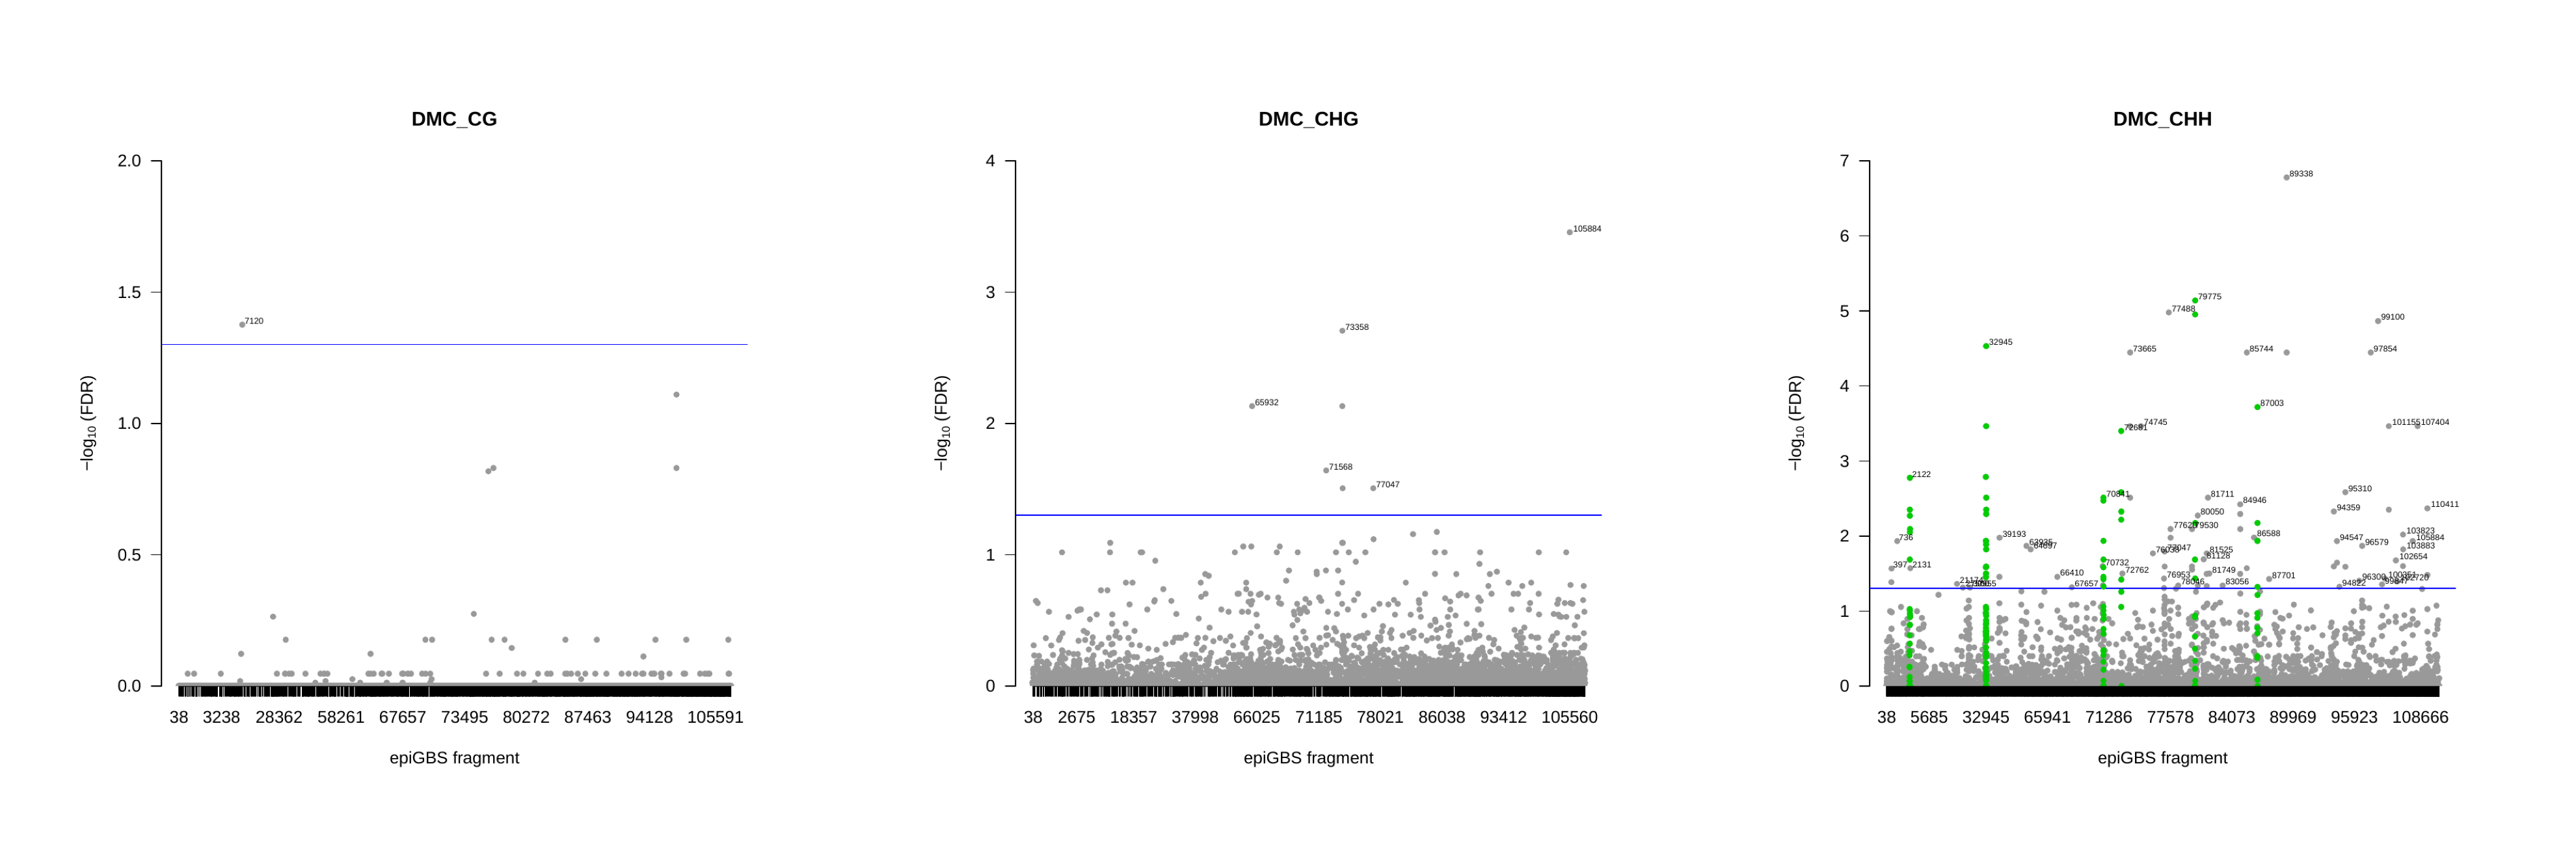

In [ ]:
#@title ejecutar
# python imports & install
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
!apt-get install poppler-utils > /dev/null
# pdf -> png
!pdftoppm /content/plots/CG_manhattanPlot.pdf CG_manhattanPlot -png
!pdftoppm /content/plots/CHG_manhattanPlot.pdf CHG_manhattanPlot -png
!pdftoppm /content/plots/CHH_manhattanPlot.pdf CHH_manhattanPlot -png

figs, axs = plt.subplots(1,3, dpi=1200, figsize=(4,4))

after_img  = mpimg.imread('CG_manhattanPlot-1.png')
midle_img = mpimg.imread('CHG_manhattanPlot-1.png')
before_img = mpimg.imread('CHH_manhattanPlot-1.png')

axs[0].imshow(after_img)
axs[0].axis('off')

axs[1].imshow(midle_img)
axs[1].axis('off')

axs[2].imshow(before_img)
axs[2].axis('off')

plt.show()


<a name="step-3"></a>
# OPCIONAL: Guardar en Drive

Opcional. 
Depende del espacio disponible en Drive.
Si desea copiar los datos, debe eliminar el numeral (`#`) de cada línea de código EXCEPTO la primera ``#@title``

In [ ]:
#@title Guardar archivos en el Drive personal
%%bash
#mkdir ../drive/MyDrive/EpiEvo/TP_4
#cd ..
#cp -r {plots,rawData,results} drive/MyDrive/EpiEvo/TP_4/
#ls drive/MyDrive/EpiEvo/TP_4